<a href="https://colab.research.google.com/github/CelikAbdullah/deep-learning-notebooks/blob/main/Computer%20Vision/applications/image%20classification/Dog_Cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the dataset from Kaggle

The Dogs vs. Cats dataset we are going to use for image classification is not provided by Keras for us. It was made public by Kaggle in late 2013. It contains images of dogs and cats.

To download the dataset, we perform the following steps:

First, we upload my API's key JSON file

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"codingwitchac","key":"75db4aef7de555ed6c056754eccc9a57"}'}

Now, we create a .kaggle folder and copy the JSON file into it

In [2]:
!rm -rf ~/.kaggle

In [3]:
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

After copying is done, we download the dogs-vs-cats dataset.

In [6]:
!kaggle competitions download -c dogs-vs-cats

 99% 804M/812M [00:05<00:00, 170MB/s]
100% 812M/812M [00:05<00:00, 147MB/s]


Now, we unzip the train.zip folder.

In [7]:
!unzip -qq dogs-vs-cats.zip

In [8]:
!unzip -qq train.zip

# Create a training, validation and test set

In [9]:
import os, shutil, pathlib

In [10]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_dataset")

In [11]:
def create_dataset(subset_name, start_index, end_index):
  for category in ("cat", "dog"):
    dir = new_base_dir/subset_name/category
    os.makedirs(dir)

    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]

    for fname in fnames:
      shutil.copyfile(src=original_dir/fname, dst=dir/fname)

In [12]:
create_dataset("train", start_index=0, end_index=11500)
create_dataset("validation",start_index=11500, end_index=12000)
create_dataset("test", start_index=12000, end_index=12500)

# Create the model

A convolutional neural network (CNN) performs recognition by detecting and classifying features (patterns). A convolutional layer is used to detect features within an image. To achieve that, it uses a bunch of filters. Each filter acts as a feature detector looking for a certain pattern. We can think of a filter as a small window sliding over the input to detect a pattern. At each location, an operation (involving the pixel values at that location & the filter values) is performed to detect the likely presence of a particular feature. That operation will generate a value which indicates how strongly the feature was detected at that location in the image. After that operation is made to every location in the input, the filter has created a so called "feature map" which is a mapping that indicates how strongly the feature (the filter was looking for) is detected at a particular location in the input.

From a technical point of view, filters are matrices containing the weights that are learned by the network during training. At the beginning, they are initalized randomly and then get updated by the optimizer after each epoch based on the loss.

A very simple CNN consists of a feature extraction part and a classification part. In general, the feature extraction part uses a stack of convolutional layers to extract features (patterns) from the input data and pooling layers to downsample the feature maps produced by the filters of the convolutional layers. In the following, you can see a function used to build such a feature extraction component of a CNN:

In [13]:
from tensorflow import keras

In [14]:
# define the part that performs the feature extraction
def extractFeatures(rescaled_inputs):

  x = keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(rescaled_inputs)
  x = keras.layers.MaxPooling2D(pool_size=2)(x)
  x = keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
  x = keras.layers.MaxPooling2D(pool_size=2)(x)
  x = keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
  x = keras.layers.MaxPooling2D(pool_size=2)(x)
  x = keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
  x = keras.layers.MaxPooling2D(pool_size=2)(x)
  x = keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

  return x

We specify the following in a convolutional layer:

*   **the number of filters**; each filter is looking for a particular feature and producing a feature map
*   **the size of the filters**; usually 3x3
*   **stride**; the rate that the filter is slid across the input
*   **padding**; to decide whether the pixel values at the edge of the input will be taken into account or not  

The idea behind such a network:


*   early layers learn coarse features
*   the subsequent layers learn finer features by increasing the number of filters
*   the max pooling layer is used between the conv layers to minimize the dimensions of the feature maps

As mentioned, the other part of CNN is the component performing the classification. Since the output coming from the feature extraction part is a 3D tensor, we have to flatten the input before it gets passed to the first Dense layer. Note that a Dense layer expects a 1D tensor as input.

Typically, this part contains some Dense layers to perform a specific task (such as image classification).
In our case, we have just one Dense layer with one neuron that creates the output of the network:

In [15]:
# define the part that performs the classification
def classification(features):
  # flatten the input
  x = keras.layers.Flatten()(features)
  x = keras.layers.Dense(1, activation="sigmoid")(x)

  return x

Since we have a binary classification problem (dog or cat), we put a Dense layer with one neuron and a sigmoid activation function at the end of the classification part.

After putting all pieces together, we can create model using the Functional API as you can see below:

In [16]:
# define the input shape
inputs = keras.Input(shape=(90,90,3))

# normalize the input data to speed up the learning process (it is better when the pixel values are all in the same range)
rescaled_inputs = keras.layers.Rescaling(1./255)(inputs)

# build the feature extraction component
features = extractFeatures(rescaled_inputs)

# build the classification component
outputs =  classification(features)

# build the model
model = keras.Model(inputs=inputs, outputs=outputs, name="my_cnn_model")

In [17]:
model.summary()

Model: "my_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90, 90, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 90, 90, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 88, 88, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 44, 44, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 64)       0         
 2D)                                                  

As we can see, the model consists of a stack of Conv2D and MaxPooling2D layers. A typical pattern see from the output of each layer: **the depth of the feature maps increases and the size (width & height) of the feature maps decreases**.

# Configure the training

In this step, we prepare the model for the training process. That means, we tell the model which loss function to use (here: BinaryCrossEntropy), which optimizer to use to update the parameters (here: Adam) and the metric (here: accuracy).

After defining that setting, we invoke the compile() method on our model.

In [18]:
# define the optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

# compile the optimizer
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Get the data from the directory

Using the utility image_dataset_from_directory() function from the keras.utils package, we can bring the images located in the directory to the model. It helps us to build a data pipeline able to turn image files on disk into batches of preprocessed tensors.

In [19]:
base_direction = "/content/cats_vs_dogs_dataset/"

train_dataset = keras.utils.image_dataset_from_directory(
    base_direction +  "train",
    image_size = (90,90),
    batch_size = 32
)

validation_dataset = keras.utils.image_dataset_from_directory(
    base_direction + "validation",
    image_size = (90,90),
    batch_size = 32
)

test_dataset = keras.utils.image_dataset_from_directory(
    base_direction + "test",
    image_size = (90,90),
    batch_size = 32
)

Found 23000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


# Define callbacks

In the following, we define two callbacks:


*   **ModelCheckPoint**
*   **EarlyStopping**

The **ModelCheckPoint** callback can be used to save the model (its weights). Since we passed the arguments **save_best_only=True** and **monitor="val_loss"**, it saves our model as a new file only then when the model reaches a lower validation loss compared to a previous epoch.

As the name implies, the **EarlyStopping** callback is used to stop the training process if the training does not get better. In our case, by passing the arguments **monitor="val_accuracy"** and **patience=2**, we tell the callback to stop the training process when the validation accuracy values does not get higher for two epochs.

In [20]:
callbacks = [
    # save the model whenever the validation loss gets lower
    keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/my_cnn_model.keras",
                                    save_best_only=True,
                                    monitor="val_loss"),
    # stop training when the validation accuracy is not getting higher for two epochs
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2)
]

# Train the model

We can start the training process using the fit() method. Here, we only specify the dataset for training, the dataset for validation, the epoch number and the callbacks that should be used.

In [21]:
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=validation_dataset,
                    callbacks=callbacks
)

Epoch 1/5
719/719 [==============================] - 513s 711ms/step - loss: 0.6280 - accuracy: 0.6321 - val_loss: 0.5487 - val_accuracy: 0.7220
Epoch 2/5
719/719 [==============================] - 502s 697ms/step - loss: 0.5030 - accuracy: 0.7526 - val_loss: 0.4942 - val_accuracy: 0.7510
Epoch 3/5
719/719 [==============================] - 494s 687ms/step - loss: 0.4405 - accuracy: 0.7937 - val_loss: 0.4477 - val_accuracy: 0.7940
Epoch 4/5
719/719 [==============================] - 489s 680ms/step - loss: 0.3931 - accuracy: 0.8211 - val_loss: 0.4208 - val_accuracy: 0.8110
Epoch 5/5
719/719 [==============================] - 488s 678ms/step - loss: 0.3568 - accuracy: 0.8427 - val_loss: 0.4168 - val_accuracy: 0.8180


# Plot the results

In this step, we can use the history object returned by the fit() method earlier to plot all the accuracy and losses on the training

In [22]:
import matplotlib.pyplot as plt

In [23]:
# define a function we can use to print the training and validation loss
def printTrainingAndValidationLoss(history):
  losses = history.history["loss"]
  val_losses = history.history["val_loss"]
  epochs = range(1, len(val_losses) + 1)

  plt.plot(epochs, losses, color="red", linestyle="solid", label="Traininig loss", linewidth=3)
  plt.plot(epochs, val_losses, color="green", linestyle="solid", label="Validation loss", linewidth=3)

  plt.title("Training and validation losses")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

In [24]:
# define a function we can use to print the training and validation accuracy
def printTrainingAndValidationAccuracy(history):
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]
  epochs = range(1, len(val_acc) + 1)
  plt.plot(epochs, acc, color="red", linestyle="solid", label="Traininig accuracy", linewidth=3)
  plt.plot(epochs, val_acc, color="green", linestyle="solid", label="Validation accuracy", linewidth=3)

  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

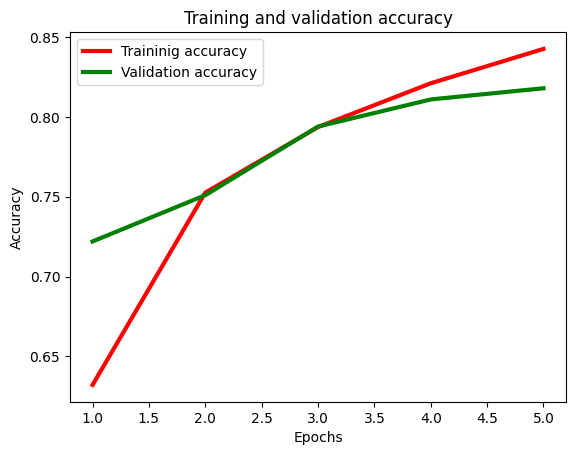

In [25]:
# print the training and validation accuracy
printTrainingAndValidationAccuracy(history)

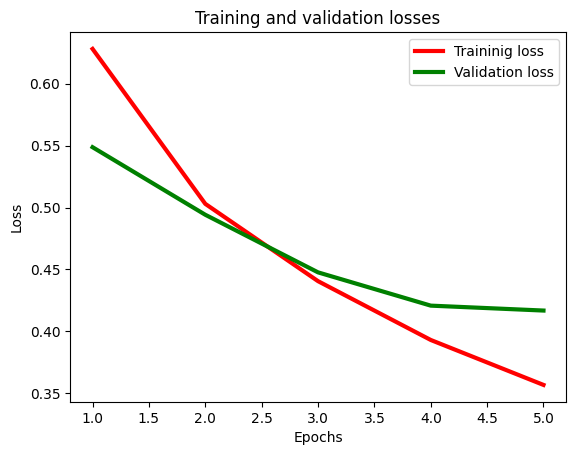

In [26]:
# print the training and validation loss
printTrainingAndValidationLoss(history)

We can observe that the model starts overfitting after 3th epoch. From then on, the validation accuracy is decreasing, while the training accuracy is increasing. That means that the model is memorizing the the input and does not generalize. If we look at the training and validation losses, we can also see signs of overfitting: the training loss is decreasing (the model has a good performance on the training data) but the validation loss is increasing (the model has a bad performance on the validation data).

# Evaluate the model

After training, we evaluate our model by calling the evaluate() method. It evaluates our trained model by passing it the test dataset which contains dog and cat images it has never seen before.

In [27]:
model.evaluate(test_dataset)

32/32 [==============================] - 7s 214ms/step - loss: 0.3873 - accuracy: 0.8380


[0.38725391030311584, 0.8379999995231628]

As we can see from the output, our trained model reaches a test accuracy of about 83%.  